In [2]:
import pyspark
import re
import pyspark.sql
from pyspark.sql import *
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
import json
from pyspark.sql.types import *
import builtins

spark = sqlContext = SQLContext(sc)

%matplotlib inline

sc.addPyFile("/home/piccardi/libs/seaborn-0.9.0-py3.5.egg")
import seaborn as sns


In [2]:
filter_30_days = "event_time >= '2019-03-24' AND event_time <= '2019-04-20' AND page_id > 0"
anonymous_citationusage = spark.read.parquet("april_anonymous_citationusage.parquet")\
                                            .where(filter_30_days).where("action <> 'pageLoad'")
pageloads_april = spark.read.parquet("april_anonymous_pageloads.parquet")\
                                            .where(filter_30_days)
unique_sessions = pageloads_april.select("session_token").distinct()
anonymous_citationusage.registerTempTable("anonymous_citationusage")
unique_sessions.registerTempTable("unique_sessions")

query = """
select anonymous_citationusage.* 
from anonymous_citationusage
join unique_sessions
on anonymous_citationusage.session_token = unique_sessions.session_token
"""

citationusage_april = spark.sql(query)

In [3]:
filter_30_days = "event_time >= '2018-09-26' AND event_time <= '2018-10-24' AND page_id > 0"
anonymous_citationusage = spark.read.parquet("anonymous_citationusage.parquet")\
                                            .where(filter_30_days).where("action <> 'pageLoad'")
pageloads_october = spark.read.parquet("anonymous_pageloads.parquet")\
                                            .where(filter_30_days)

unique_sessions = pageloads_october.select("session_id").distinct()
anonymous_citationusage.registerTempTable("anonymous_citationusage")
unique_sessions.registerTempTable("unique_sessions")

query = """
select anonymous_citationusage.*
from anonymous_citationusage
join unique_sessions
on anonymous_citationusage.session_id = unique_sessions.session_id
"""

citationusage_october = spark.sql(query)

In [4]:
# Select the clicks or references
reference_clicks = citationusage_april.where("action='extClick' and footnote_number is not null")

# Count the number of unique loads (distinct in one session)
pageviews_count = pageloads_april.groupBy("page_id").agg(countDistinct("session_token").alias("pageviews"))

# Count in how many loads there is at least 1 click
pageviews_with_clicks = reference_clicks.groupBy("page_id")\
                        .agg(countDistinct("session_token").alias("pageviews_with_clicks"))


pageviews_count.registerTempTable("pageviews_count")
pageviews_with_clicks.registerTempTable("pageviews_with_clicks")

query = """
SELECT pv.*, CASE WHEN pc.page_id is NULL THEN 0 ELSE pageviews_with_clicks END as pageviews_with_clicks
FROM pageviews_count pv
LEFT JOIN pageviews_with_clicks pc
ON pv.page_id = pc.page_id
"""

pages_ct_april = spark.sql(query).selectExpr("*", "pageviews_with_clicks/pageviews as page_ct")
pages_ct_april.cache()

DataFrame[page_id: bigint, pageviews: bigint, pageviews_with_clicks: bigint, page_ct: double]

In [5]:
# Select the clicks or references
reference_clicks = citationusage_october.where("action='extClick' and footnote_number is not null")

# Count the number of unique loads (distinct in one session)
pageviews_count = pageloads_october.groupBy("page_id").agg(countDistinct("session_id").alias("pageviews"))

# Count in how many loads there is at least 1 click
pageviews_with_clicks = reference_clicks.groupBy("page_id")\
                        .agg(countDistinct("session_id").alias("pageviews_with_clicks"))


pageviews_count.registerTempTable("pageviews_count")
pageviews_with_clicks.registerTempTable("pageviews_with_clicks")

query = """
SELECT pv.*, CASE WHEN pc.page_id is NULL THEN 0 ELSE pageviews_with_clicks END as pageviews_with_clicks
FROM pageviews_count pv
LEFT JOIN pageviews_with_clicks pc
ON pv.page_id = pc.page_id
"""

pages_ct_october = spark.sql(query).selectExpr("*", "pageviews_with_clicks/pageviews as page_ct")
pages_ct_october.cache()

DataFrame[page_id: bigint, pageviews: bigint, pageviews_with_clicks: bigint, page_ct: double]

In [6]:
wikicode_oct = spark.read.parquet("wikipedia_wikicode_oct2018.parquet")
wikicode_oct

DataFrame[page_id: bigint, revision_id: bigint, text: string, title: string]

In [7]:
wikicode_apr = spark.read.parquet("features/wikipedia_apr2019.parquet")
wikicode_apr

DataFrame[page_id: bigint, wikicode: string, wikicode_len: bigint, title: string, revision_id: bigint, text_length: int, references_count: int, qualities_vector: vector, quality: map<string,double>, topics: map<string,double>, topics_vector: vector]

Get the difference

In [14]:
growth_stats = pages_ct_october.alias("ct_oct")\
    .join(pages_ct_april.alias("ct_apr"), pages_ct_october.page_id==pages_ct_april.page_id)\
    .join(wikicode_oct.alias("wikicode_oct"), pages_ct_october.page_id==wikicode_oct.page_id)\
    .join(wikicode_apr.alias("wikicode_apr"), pages_ct_october.page_id==wikicode_apr.page_id)\
    .selectExpr("ct_oct.page_id", "ct_oct.pageviews as pageviews_oct", "ct_oct.page_ct as page_ct_oct",
               "ct_apr.pageviews as pageviews_apr", "ct_apr.page_ct as page_ct_apr",
               "length(wikicode_oct.text) as length_oct", "wikicode_apr.wikicode_len as length_apr")\
    .cache()

growth_stats

DataFrame[page_id: bigint, pageviews_oct: bigint, page_ct_oct: double, pageviews_apr: bigint, page_ct_apr: double, length_oct: int, length_apr: bigint]

In [15]:
growth_stats.count()

4902164

Limit to articles with at least 100 pageviews

In [16]:
growth_stats100 = growth_stats.where("pageviews_oct>=100 and pageviews_apr>=100")

In [17]:
growth_stats100.count()

966215

In [18]:
growth_stats100.show()

+-------+-------------+--------------------+-------------+--------------------+----------+----------+
|page_id|pageviews_oct|         page_ct_oct|pageviews_apr|         page_ct_apr|length_oct|length_apr|
+-------+-------------+--------------------+-------------+--------------------+----------+----------+
|   1677|         6104| 4.91480996068152E-4|         6012|1.663339986693280...|     43955|     42710|
|   1697|         7956|0.001508295625942...|         9421|0.001698333510243074|     23088|     24510|
|   1806|        87381|6.179833144505098E-4|        88478|6.103212097922648E-4|    159828|    162743|
|   1950|         6580|0.004407294832826748|         5714|0.004725236261813091|    182621|    185086|
|   2250|          604|0.009933774834437087|          758|0.009234828496042216|     26290|     25929|
|   2529|         1173|                 0.0|         1041|9.606147934678194E-4|     12228|     12776|
|   2927|         7180|8.356545961002785E-4|         7029|5.690709916062028E-4|   

In [36]:
gs = growth_stats100.toPandas()

In [37]:
gs.head()

,page_id,pageviews_oct,page_ct_oct,pageviews_apr,page_ct_apr,length_oct,length_apr
0,1677,6104,0.000491,6012,0.000166,43955,42710
1,1697,7956,0.001508,9421,0.001698,23088,24510
2,1806,87381,0.000618,88478,0.000610,159828,162743
3,1950,6580,0.004407,5714,0.004725,182621,185086
4,2250,604,0.009934,758,0.009235,26290,25929


In [38]:
len(gs)

966215

In [39]:
gs.describe()

,page_id,pageviews_oct,page_ct_oct,pageviews_apr,page_ct_apr,length_oct,length_apr
count,9.662150e+05,966215.000000,966215.000000,9.662150e+05,966215.000000,966215.000000,966215.000000
mean,1.496913e+07,1182.317329,0.004131,1.193693e+03,0.004130,17227.627786,17703.419372
std,1.709554e+07,4716.568081,0.007620,5.658095e+03,0.007523,22812.263353,23117.225455
min,1.200000e+01,100.000000,0.000000,1.000000e+02,0.000000,96.000000,83.000000
25%,1.461886e+06,178.000000,0.000000,1.820000e+02,0.000000,5489.000000,5669.000000
50%,6.217695e+06,334.000000,0.001097,3.400000e+02,0.001161,10132.000000,10440.000000
75%,2.585057e+07,839.000000,0.005391,8.520000e+02,0.005410,19654.000000,20231.000000
max,5.885397e+07,964136.000000,0.373585,1.917864e+06,0.574429,828329.000000,481391.000000


-------
Plotting

In [55]:
means_oct = []
means_apr = []
means_diff = []

rng = [e for e in np.arange(1, 10, 0.5)]

import numpy as np
for i in rng:
    step = gs[(i*gs.length_oct<gs.length_apr) & (gs.page_ct_oct>0)&(gs.page_ct_apr>0)]
    means_oct.append(step.page_ct_oct.mean())
    means_apr.append(step.page_ct_apr.mean())
    means_diff.append(step.page_ct_oct.mean()-step.page_ct_apr.mean())

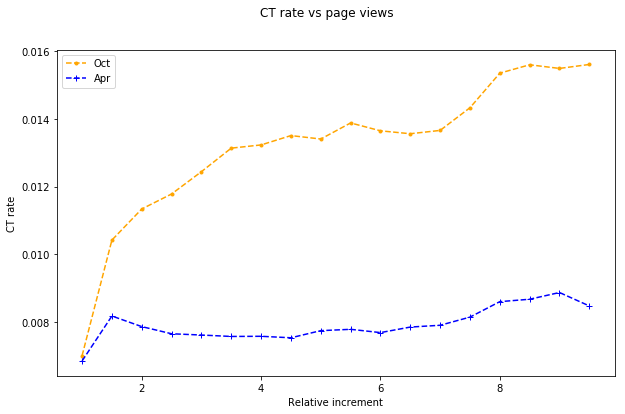

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))


ax.plot(rng, means_oct, linestyle='--', marker=".", color="orange", label="Oct")
ax.plot(rng, means_apr, linestyle='--', marker="+", color="blue", label="Apr")
ax.legend()


fig.suptitle('CT rate vs page views')

plt.xlabel("Relative increment")

plt.ylabel('CT rate')


In [63]:
import builtins
import math
max_pageviews = builtins.max(gs.pageviews_apr.max(), gs.pageviews_oct.max())
print(max_pageviews)
print(math.log(max_pageviews))

1917864
14.466722624716493


Binning in logspace

In [69]:
bins = np.logspace(4.6, 14, 30, base=2.718281828459045)
bins

array([  9.94843156e+01,   1.37570695e+02,   1.90237989e+02,
         2.63068326e+02,   3.63780886e+02,   5.03050043e+02,
         6.95636731e+02,   9.61952927e+02,   1.33022509e+03,
         1.83948584e+03,   2.54371098e+03,   3.51754028e+03,
         4.86418848e+03,   6.72638481e+03,   9.30150073e+03,
         1.28624689e+04,   1.77867112e+04,   2.45961407e+04,
         3.40124788e+04,   4.70337491e+04,   6.50400570e+04,
         8.99398643e+04,   1.24372265e+05,   1.71986698e+05,
         2.37829746e+05,   3.28880018e+05,   4.54787796e+05,
         6.28897860e+05,   8.69663878e+05,   1.20260428e+06])

In [74]:
def get_bin(pv):
    for i in range(1, len(bins)):
        if pv >= bins[i-1] and pv < bins[i]:
            return i
    return -1

gs["pageviews_apr_bin"] = gs.pageviews_apr.apply(get_bin)
gs["pageviews_oct_bin"] = gs.pageviews_oct.apply(get_bin)

gs.head()

,page_id,pageviews_oct,page_ct_oct,pageviews_apr,page_ct_apr,length_oct,length_apr,pageviews_apr_bin,pageviews_oct_bin
0,1677,6104,0.000491,6012,0.000166,43955,42710,13,13
1,1697,7956,0.001508,9421,0.001698,23088,24510,15,14
2,1806,87381,0.000618,88478,0.000610,159828,162743,21,21
3,1950,6580,0.004407,5714,0.004725,182621,185086,13,13
4,2250,604,0.009934,758,0.009235,26290,25929,7,6


In [77]:
means_oct = []
means_apr = []
means_diff = []

rng = [e for e in np.arange(1, 10, 1)]

import numpy as np
for i in rng:
    step = gs[(i*gs.length_oct<gs.length_apr) & (gs.page_ct_oct>0)
              &(gs.page_ct_apr>0) & (gs.pageviews_oct_bin==gs.pageviews_apr_bin)]
    means_oct.append(step.page_ct_oct.mean())
    means_apr.append(step.page_ct_apr.mean())
    means_diff.append(step.page_ct_oct.mean()-step.page_ct_apr.mean())

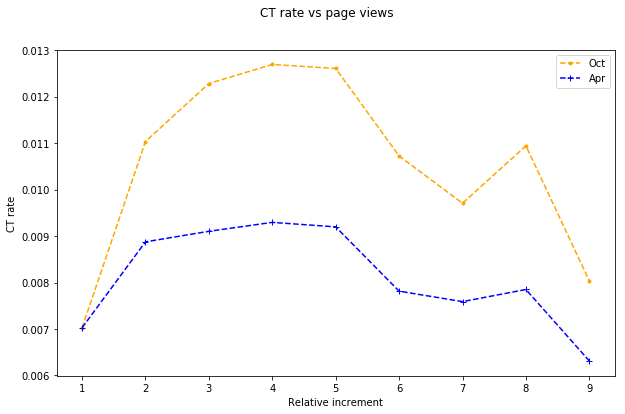

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))


ax.plot(rng, means_oct, linestyle='--', marker=".", color="orange", label="Oct")
ax.plot(rng, means_apr, linestyle='--', marker="+", color="blue", label="Apr")
ax.legend()


fig.suptitle('CT rate vs page views')

plt.xlabel("Relative increment")

plt.ylabel('CT rate')


In [8]:
from scipy.stats import binned_statistic
import numpy as np
import builtins
import math

def get_stats(bin_samples, stat_type="mean"):
    if len(bin_samples)<1:
        return 
    means_list = []
    for i in range(0, 100):
        samples = np.random.choice(bin_samples, size=len(bin_samples))
        means_list.append(np.mean(samples))
    means_list = sorted(means_list)
    if stat_type=="mean":
        return means_list[len(means_list)//2]
    elif stat_type=="left":
        left_index = int(0.05*len(means_list))
        return means_list[left_index]
    elif stat_type=="right":
        right_index = builtins.min(len(means_list)-1, math.ceil(0.95*len(means_list)))
        return means_list[right_index]
    
def get_stats_median(bin_samples, stat_type="median"):
    if len(bin_samples)<1:
        return 
    median_list = []
    for i in range(0, 100):
        samples = np.random.choice(bin_samples, size=len(bin_samples))
        median_list.append(np.median(samples))
    median_list = sorted(median_list)
    if stat_type=="median":
        return median_list[len(median_list)//2]
    elif stat_type=="left":
        left_index = int(0.05*len(median_list))
        return median_list[left_index]
    elif stat_type=="right":
        right_index = builtins.min(len(median_list)-1, math.ceil(0.95*len(median_list)))
        return median_list[right_index]


[120619, 6327, 2670, 1572, 1054, 762, 579, 468, 386, 297, 242, 212, 182, 155, 130, 109]


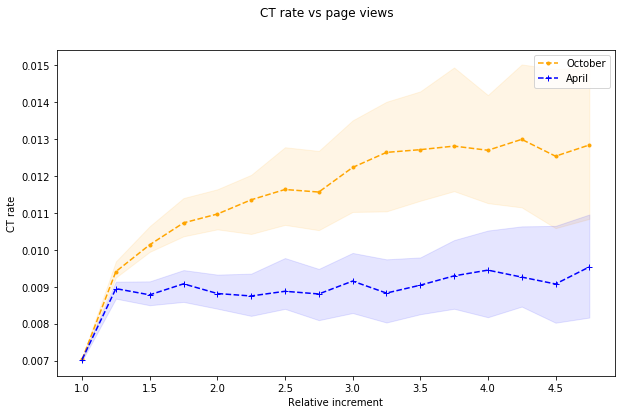

In [111]:
rng = [e for e in np.arange(1, 5, 0.25)]

mean_oct = []
mean_apr = []

left_oct = []
left_apr = []

right_oct = []
right_apr = []

samples = []

import numpy as np
for i in rng:
    step = gs[(i*gs.length_oct<gs.length_apr) & (gs.page_ct_oct>0)
              &(gs.page_ct_apr>0) & (gs.pageviews_oct_bin==gs.pageviews_apr_bin)]
    samples.append(len(step))
    mean_oct.append(get_stats(step.page_ct_oct, "mean"))
    left_oct.append(get_stats(step.page_ct_oct, "left"))
    right_oct.append(get_stats(step.page_ct_oct, "right"))
    mean_apr.append(get_stats(step.page_ct_apr, "mean"))
    left_apr.append(get_stats(step.page_ct_apr, "left"))
    right_apr.append(get_stats(step.page_ct_apr, "right"))
    
print(samples)
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(rng, mean_oct, linestyle='--', marker=".", color="orange", label="October")
ax.fill_between(rng, left_oct,right_oct, color = 'orange',alpha = 0.1)
ax.plot(rng, mean_apr, linestyle='--', marker="+", color="blue", label="April")
ax.fill_between(rng, left_apr,right_apr, color = 'blue',alpha = 0.1)
ax.legend()
fig.suptitle('CT rate vs page views')
plt.xlabel("Relative increment")
plt.ylabel('CT rate')

In [121]:
gs['variation'] = (gs['length_apr']/gs['length_oct'])
gs.head()

,page_id,pageviews_oct,page_ct_oct,pageviews_apr,page_ct_apr,length_oct,length_apr,pageviews_apr_bin,pageviews_oct_bin,variation
0,1677,6104,0.000491,6012,0.000166,43955,42710,13,13,0.971676
1,1697,7956,0.001508,9421,0.001698,23088,24510,15,14,1.061590
2,1806,87381,0.000618,88478,0.000610,159828,162743,21,21,1.018238
3,1950,6580,0.004407,5714,0.004725,182621,185086,13,13,1.013498
4,2250,604,0.009934,758,0.009235,26290,25929,7,6,0.986269


In [4]:
import numpy as np
rng = np.logspace(0, 1.5, 10, base=2.718281828459045)

In [5]:
labels = rng[:-1]
gs["variation_bin"] = pd.cut(gs.variation, bins=rng, labels=labels)
gs["ct_diff"] = gs["page_ct_apr"]-gs["page_ct_oct"]
gs["ct_diff_ratio"] = gs["page_ct_apr"]/gs["page_ct_oct"]

In [6]:
gs_limited = gs[(gs.length_apr>gs.length_oct) & (gs.page_ct_oct>0) & (gs.page_ct_apr>0) 
                & (gs.pageviews_oct_bin==gs.pageviews_apr_bin)].dropna()

#### Relative increment vs CT rate

[111434, 5579, 1699, 775, 404, 252, 170, 99]


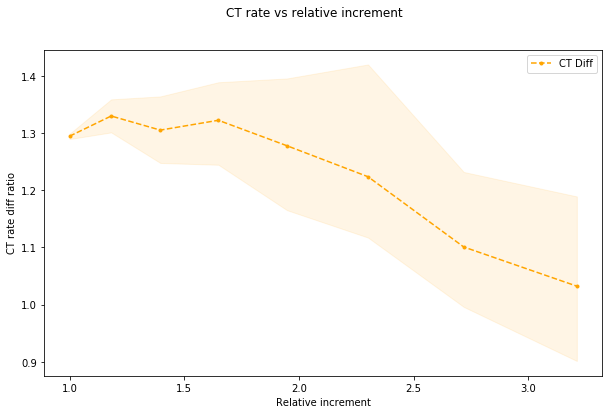

In [10]:
rng = rng[:-1]

mean_diff = []
left_diff = []
right_diff = []

samples = []

import numpy as np
for i in rng:
    step = gs_limited[gs_limited.variation_bin==i]
    samples.append(len(step))
    mean_diff.append(get_stats(step.ct_diff_ratio, "mean"))
    left_diff.append(get_stats(step.ct_diff_ratio, "left"))
    right_diff.append(get_stats(step.ct_diff_ratio, "right"))
    
print(samples)
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(rng, mean_diff, linestyle='--', marker=".", color="orange", label="CT Diff")
ax.fill_between(rng, left_diff, right_diff, color = 'orange',alpha = 0.1)
ax.legend()
fig.suptitle('CT rate vs relative increment')
plt.xlabel("Relative increment")
plt.ylabel('CT rate diff ratio')

In [9]:
mean_oct = []
mean_apr = []

left_oct = []
left_apr = []

right_oct = []
right_apr = []

samples = []

increment = []

import numpy as np
for b in sorted(gs_limited.variation_bin.unique()):
    step = gs_limited[gs_limited.variation_bin==b]
    samples.append(len(step))
    increment.append(b)
    mean_oct.append(get_stats(step.page_ct_oct, "mean"))
    left_oct.append(get_stats(step.page_ct_oct, "left"))
    right_oct.append(get_stats(step.page_ct_oct, "right"))
    mean_apr.append(get_stats(step.page_ct_apr, "mean"))
    left_apr.append(get_stats(step.page_ct_apr, "left"))
    right_apr.append(get_stats(step.page_ct_apr, "right"))



In [21]:
print(mean_oct)
print(mean_apr)

[0.0068607484446679993, 0.0084445256317712564, 0.0092904799594001782, 0.010108644277650375, 0.010228541187764874, 0.010923340229424174, 0.0098445057678816419, 0.010774173081677812, 0.013657344490052707]
[0.0068898968003457016, 0.0085055812383736367, 0.0087340610146153207, 0.0092314265851527397, 0.0090700516031585274, 0.0091402580835049374, 0.0083664677363388153, 0.0077432168754613387, 0.0097858025108990623]


In [261]:
len(gs_limited)

120488

In [97]:
gs_limited.head(1)

,page_id,pageviews_oct,page_ct_oct,pageviews_apr,page_ct_apr,length_oct,length_apr,pageviews_apr_bin,pageviews_oct_bin,variation,variation_bin,ct_diff,ct_diff_ratio
2,1806,87381,0.000618,88478,0.00061,159828,162743,21,21,1.018238,1.0,-0.000008,0.987601


In [18]:
len(gs_limited)

120488

Difference of pageviews in every bin

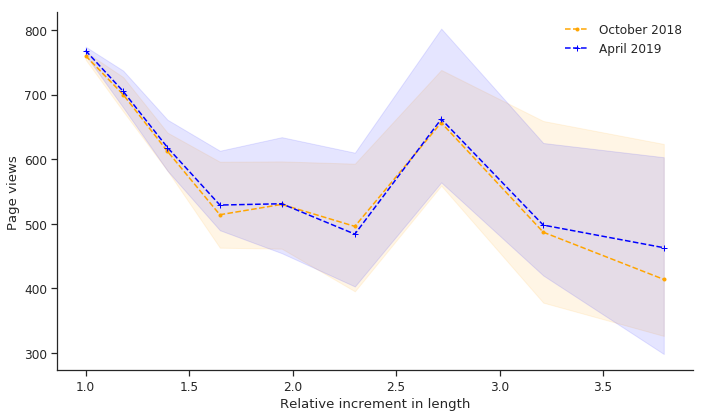

In [13]:
mean_oct = []
mean_apr = []

left_oct = []
left_apr = []

right_oct = []
right_apr = []

samples = []

increment = []

import numpy as np
for b in sorted(gs_limited.variation_bin.unique()):
    step = gs_limited[gs_limited.variation_bin==b]
    samples.append(len(step))
    increment.append(b)
    mean_oct.append(get_stats_median(step.pageviews_oct, "median"))
    left_oct.append(get_stats_median(step.pageviews_oct, "left"))
    right_oct.append(get_stats_median(step.pageviews_oct, "right"))
    mean_apr.append(get_stats_median(step.pageviews_apr, "median"))
    left_apr.append(get_stats_median(step.pageviews_apr, "left"))
    right_apr.append(get_stats_median(step.pageviews_apr, "right"))

plt.figure(figsize=(5, 3), frameon=False)

sns.set_context("paper")
sns.set(font_scale = 1.1)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})


fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot(increment, mean_oct, linestyle='--', marker=".", color="orange", label="October 2018")
ax.fill_between(increment, left_oct,right_oct, color = 'orange',alpha = 0.1)
ax.plot(increment, mean_apr, linestyle='--', marker="+", color="blue", label="April 2019")
ax.fill_between(increment, left_apr,right_apr, color = 'blue',alpha = 0.1)
ax.legend()
# fig.suptitle('CT rate vs page views')
plt.xlabel("Relative increment in length")
plt.ylabel('Page views')

leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.tight_layout()

# plt.savefig('oct_apr_diff.pdf', bbox_inches='tight')


In [33]:
def get_pageloads_median():
    mean_oct = []
    mean_apr = []

    left_oct = []
    left_apr = []

    right_oct = []
    right_apr = []

    samples = []

    increment = []

    import numpy as np
    for b in sorted(gs_limited.variation_bin.unique()):
        step = gs_limited[gs_limited.variation_bin==b]
        samples.append(len(step))
        increment.append(b)
        mean_oct.append(get_stats(step.pageviews_oct, "mean"))
        left_oct.append(get_stats(step.pageviews_oct, "left"))
        right_oct.append(get_stats(step.pageviews_oct, "right"))
        mean_apr.append(get_stats(step.pageviews_apr, "mean"))
        left_apr.append(get_stats(step.pageviews_apr, "left"))
        right_apr.append(get_stats(step.pageviews_apr, "right"))
    return mean_oct, left_oct, right_oct, mean_apr, left_apr, right_apr

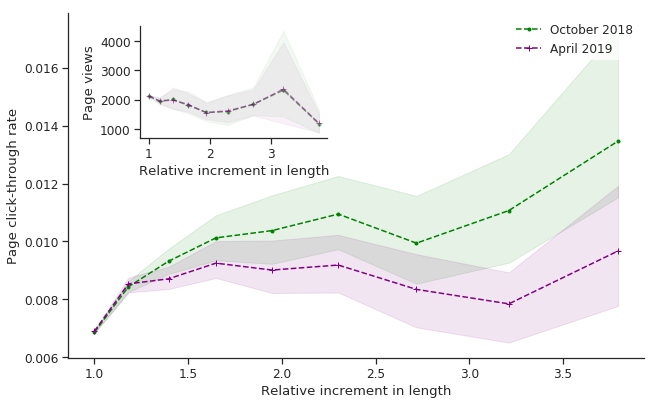

In [95]:
# plt.figure(figsize=(10, 6), frameon=False)

sns.set_context("paper")
sns.set(font_scale = 1.1)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})


fig = plt.figure(figsize=(10, 6), frameon=False)
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax2 = fig.add_axes([0.2, 0.61, 0.26, 0.26])


# pv_mean_oct, pv_left_oct, pv_right_oct, pv_mean_apr, pv_left_apr, pv_right_apr = get_pageloads_median()

ax2.plot(increment, pv_mean_oct, linestyle='--', marker=".", color="green", label="October 2018", alpha = 0.5)
ax2.fill_between(increment, pv_left_oct, pv_right_oct, color = 'green',alpha = 0.05)
ax2.plot(increment, pv_mean_apr, linestyle='--', marker="+", color="purple", label="April 2019", alpha = 0.5)
ax2.fill_between(increment, pv_left_apr,pv_right_apr, color = 'purple',alpha = 0.05)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_xlabel("Relative increment in length")
ax2.set_ylabel('Page views')



ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.plot(increment, mean_oct, linestyle='--', marker=".", color="green", label="October 2018")
ax1.fill_between(increment, left_oct,right_oct, color = 'green',alpha = 0.1)
ax1.plot(increment, mean_apr, linestyle='--', marker="+", color="purple", label="April 2019")
ax1.fill_between(increment, left_apr,right_apr, color = 'purple',alpha = 0.1)
ax1.legend()

ax1.legend().get_frame().set_linewidth(0.0)

ax1.set_xlabel("Relative increment in length")
ax1.set_ylabel('Page click-through rate')


In [31]:
len(gs_limited[gs_limited.variation>1.1])

17021

No significant difference for the pages with small variation in length

In [64]:
dist = gs_limited[gs_limited.variation<1.03][['page_ct_oct', 'page_ct_apr']]

from scipy.stats import mannwhitneyu

# compare distributions
stat, p = mannwhitneyu(dist.page_ct_oct, 
                       dist.page_ct_apr,
                       alternative="two-sided")
alpha = 0.001
if p < alpha:
    print('Statistics=%.3f, p < %.3f' % (stat, alpha))
else:
    print('Statistics=%.3f, p = %.3f' % (stat, p))
# interpret
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=2851838799.500, p = 0.072
Same distribution (fail to reject H0)


In [59]:
gs_limited[gs_limited.variation<1.05][['page_ct_oct', 'page_ct_apr']].mean()

page_ct_oct    0.006771
page_ct_apr    0.006806
dtype: float64

In [57]:
len(gs_limited[gs_limited.variation<1.05])

89412